# Bug Classifcation using Natural Language Processing
The following project uses a Natural Language Processing model to read in bug descriptions submitted by the Global Customer Support Desk, internal Pega employees, and pega customers, and assign these bugs to the relevant backlogs in Agile Studio.

To perform bug assignment, we first pre-process bug descriptions and subject lines. Then, we convert each bug description to a TF/ IDF vector. Finally, we use a Deep Learning model to extract insights from the TF/IDF scores and train that model to perform accurate classifications.

At the prediction phase, we apply confidence bounding using [Monte Carlo dropout](https://arxiv.org/pdf/1506.02142.pdf). Using this approach, we can choose the threshold confidence score that best suits our needs - the model will automatically route bugs to the appropriate backlogs if it can generate a prediction above the confidence threshold (a high confidence prediction) and will route bugs that it cannot confidently place into a queue for human review. Stakeholders at Pega can choose a proper trade off between accuracy and efficiency by tweaking the confidence threshold to the desired value.

## Step 1: Install Packages.
The first script, [`install_conda.sh`](../nlp_engine/install_conda.sh), installs [miniconda](https://docs.conda.io/en/latest/miniconda.html) and sets up an environment called `nlp-workspace`. You can learn more about conda environments [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html). The environment essentially acts as a sand-boxed virtual machine where we keep all of the code dependencies. As you can see by inspecting the install script, we use python 3.7 as our base. Further, we install the `nb_conda` package. This package allows us to select an environment on a Jupyter Notebook (nb). Once the `install_conda` script has been run, you should be able to open a jupyter notebook on your host machine and select `Python (nlp-workspace)` as the kernel.


The second script, [`install_packages.sh`](../nlp_engine/install_packages.sh), installs all of the requisite python packages necessary to train the machine learning model and deploy it. After successfully running this script, the environment should have all of the necessary packages and all imports should work correctly.

In [1]:
# Uncomment this entire selection to perform the requisite installs
#%%capture # The capture tag suppresses output. Comment it out if you want to see installation script output.
#!bash ../nlp_engine/install_conda.sh
#!bash ../nlp_engine/install_packages.sh

In [2]:
# Import all needed libraries from the `nlp-workspace` environment
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Flatten, Input, Activation, PReLU, LeakyReLU, ThresholdedReLU

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pickle
from tqdm import tqdm

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.0.1
Eager mode:  True
GPU is available


## Step 2: Pull in additional libraries.
Here, we pull in additional libraries that we created to perform standard NLP test preprocessing and convenience functions for machine learning.
You can inspect the functions we pull in here by taking a look at our [`MLFunctions`](../nlp_engine/MLFunctions.py) file or our [`Preprocessing`](../nlp_engine/Preprocessing.py) file.

In [3]:
import sys
sys.path.insert(1, '../nlp_engine')
from MLFunctions import PrintDot, plot_history, clear_memory, test_with_uncertainty, \
                        predict_with_uncertainty, get_monte_carlo_accuracy, graph_confidence
from Preprocessing import preprocess_training_text, preprocess_training_text_with_stops

Spacy model is using GPU


## Step 3: Read-in and Clean Data
Here, we read in the email bug data and eliminate training examples that will not be useful to out model. Starting with the original dataset, we
1. **Eliminate** 
    - bugs that were not assigned to a backlog 
    - bugs that were not assigned to a team (i.e. bugs that were never resolved)
    - bugs that lack a description or label
    
    
2. **Remove duplicate entries, if they exist.**

3. **Remove backlogs that have been assigned less than 40 training examples.** Backlogs that have been assigned less than this number will be prone to model over-fitting, since they are so underrepresented in a dataset of the size we are working with. As such, we remove them to avoid inaccurate classifications. We settled on the number 40 after experimenting with a variety of different thresholds, but you may want to change this threshold as you collect additional training data to be fed into the model.

In [4]:
# Read in data & rename columns
email_bugs = pd.read_csv("../data/csvs/bug_emails.csv")
email_bugs = email_bugs.rename(columns={"Work ID" : "work_id", "Label" : "label", "Description" : "description", 
                             "Status" : "status", "Team ID" : "team_id", "Team Name" : "team_name", 
                             "Backlog ID" : "backlog_id", "Backlog Name" : "backlog_name", "Feature ID" : "feature_id", 
                             "Feature Name" : "feature_name"})

# 1. Eliminate:
assigned_bugs = email_bugs[email_bugs['backlog_id'].notnull()]   # bugs that were not assigned to a backlog
assigned_bugs = assigned_bugs[assigned_bugs['team_id'].notnull()]  # bugs that lack a team
assigned_bugs = assigned_bugs[assigned_bugs['description'].notnull()]  # bugs that lack a description
assigned_bugs = assigned_bugs[assigned_bugs['label'].notnull()]        # or label

# 2. Drop Duplicates:
assigned_bugs.drop_duplicates(subset = "work_id", keep = False, inplace = True) # duplicate bugs

# Visualize the dataset
assigned_bugs.head()

,work_id,label,description,status,team_id,team_name,backlog_id,backlog_name,feature_id,feature_name
0,BUG-530021,Issues with Reports and Notifications,"Hi Team,\n\n\n\nThis is to report 2 issues.\n\...",Resolved-Enhancement,PROJ-10002,Cloud - Beyonders,BL-3339,Cloud,NaN,NaN
1,BUG-528121,OPD-PROD: Pre schedule validation stuck in pro...,Pre-scheduled validation is stuck at in-progre...,Resolved-Completed,PROJ-10002,Cloud - Beyonders,BL-3339,Cloud,FR-9155,Scheduling Patch Installs
2,BUG-529279,"For inflight DBupgrde tasks, Validation tasks ...","For inflight DBupgrde tasks, Validation tasks ...",Resolved-Completed,PROJ-10002,Cloud - Beyonders,BL-3339,Cloud,FR-8238,Global Operations Console (GOC)
3,BUG-528748,Issues in Q_7.22,1. Create a VCR dispute\n\r\n2. Select Quality...,Resolved-Completed,PROJ-10005,20.1 Compliance for SD Issuers and Acquirers,GRP-15763,FS - Smart Dispute - Issuer Compliance Backlog,NaN,NaN
4,BUG-537524,Incorrect Deadline value in overview tab,Steps to reproduce:\n\n1. Login to QA server w...,New,PROJ-10005,20.1 Compliance for SD Issuers and Acquirers,GRP-15763,FS - Smart Dispute - Issuer Compliance Backlog,NaN,NaN


In [5]:
# Check current number of backlogs and samples
print("Number of backlog IDs: " , assigned_bugs['backlog_id'].nunique())
print("Number of training samples: " , len(assigned_bugs))

Number of backlog IDs:  159
Number of training samples:  7438


In [6]:
# 3. Remove backlogs that have been assigned 40 or less training examples:
former_length = len(assigned_bugs)
bugs_per_id = assigned_bugs['backlog_id'].value_counts()
valid_id_list = bugs_per_id[bugs_per_id > 40].index.tolist()
assigned_bugs = assigned_bugs[assigned_bugs['backlog_id'].isin(valid_id_list)]

print("Backlog ID's remaining:", len(valid_id_list))
print("Number of training samples remaining: " , len(assigned_bugs))
print("% of remaining training examples: ", len(assigned_bugs) / former_length)

Backlog ID's remaining: 47
Number of training samples remaining:  6245
% of remaining training examples:  0.8396074213498252


## Step 4: Preprocessing
Below, we apply the preprocessing functions we created in our [`Preprocessing`](../nlp_engine/Preprocessing.py) library to our bug descriptions and subject lines ('label'). 
**The standard preprocessing function applies the following procedures to our bug descriptions:**
- Strip HTML
- Remove non-ascii characters (i.e. Unicode)
- Remove excess whitespace (tabs, newlines, etc.)
- Convert accented chars (café -> *cafe*)
- Lowercase all characters
- Remove numbers (*see note below*)
- Remove punctuation
- Expand contractions
          don't → do not 
          I'll → I will be
- Lemmatization 
          [Playing, plays, played]→ play
          [am, are, is] → be
- Remove stop words (the most common words in the English language)
          buy a banana at market → buy banana market


**Notes**:
- You can choose to convert numbers into text (i.e. 7 -> seven) instead of removing them by setting the `convert_num` setting to `True` and the `remove_num` setting to `False`.
- Any other of the preprocessing options can be changed simply by toying with the parameters, as you can see we have done with the `preprocess_with_caps` function below.

---
### Rationale:

Each of the above procedures are designed to clean the text and increase its value in terms of the predictive power it delivers. 

**Lemmatization and contraction expansion** are designed to ensure that phrases and words that mean the same thing are always represented the same way in the text. This way, a machine learning model doesn't need to learn the relationship between play, played, plays, etc. and the prediction it is trying to make. Instead, it only needs to learn the relationship between the single word - play- and the prediction it is trying to make. Lemmatization and contraction expansion therefore work to better capture the semantic meaning of a text and remove variants that might confuse an ML model. 

**Removing stop words** helps to improve the value of a text by removing all words that lack predictive power, thus allowing an ML model to better "attend to" the words that matter.

---
### Usage:
To use our preprocessing function we use the pandas [.apply syntax](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html). When we call `dataframe.apply(function_name)`, we apply that function to all of the entries (bugs) in our DataFrame. When you run the below cells, note that the preprocessing function itself uses a pre-trained machine learning model ([from spacy](https://spacy.io/models)) to perform lemmatization and contraction expansion. As such, the process is computationally intensive. It takes a few minutes to run on a GPU machine, and likely longer on a standard CPU machine.

---

### Additional Steps:
After we finish preprocessing, we **remove all bugs that contain 10 or leas words in the description field**, as these bugs are unlikely to contain enough inferencable information. We perform this step after preprocessing so that we do not include stop words, emails, URLs, numbers, or other non-word symbols in the word count.

Its possible that bugs with this few words could have a descriptive subject line, but we found subject lines to be significantly less predictive than the description field, often including only generic descriptions or identification numbers that mean nothing to our model.

In our dataset, there are only a few hundred bugs with descriptions of 10 or less words... because we remove them, however, it's worth noting that our model is likely to perform poorly if fed extremely short emails in production unless those emails contain keywords our model has been trained to utilize.

In [7]:
def preprocess_with_stops_caps(text):
    return preprocess_training_text(text, accented_chars=True, contractions=True, 
                       convert_num=False, extra_whitespace=True, 
                       lemmatization=True, lowercase=False, punctuations=False,
                       remove_html=True, remove_num=True, special_chars=True, 
                       stop_words=True)

In [8]:
# Run this cell to perform text preprocessing
tqdm.pandas(desc="preproccessing descriptions")
assigned_bugs['description'] = assigned_bugs['description'].progress_apply(preprocess_training_text)
tqdm.pandas(desc="preproccessing labels")
assigned_bugs['label'] = assigned_bugs['label'].progress_apply(preprocess_training_text)

/root/miniconda3/envs/nlp-workspace/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
preproccessing labels: 100%|██████████| 6245/6245 [01:47<00:00, 58.16it/s]


In [9]:
# Concatenate bug labels and descriptions, and create a `combined` data column in our `assigned_bugs` dataframe. 
# We will pass this data into our ML model, since the label + description combined contains more information than 
# either text field individually.
assigned_bugs['combined'] = assigned_bugs['label'].map(str) + ' ' + assigned_bugs['description']

In [10]:
# Additional Step: Remove all bugs that contain 10 or less words in the description:
assigned_bugs = assigned_bugs[assigned_bugs['description'].str.split().apply(len) > 10]
print("Number of training samples remaining: " , len(assigned_bugs))

Number of training samples remaining:  5434


The below code snippet can be used to save pre-processed text to a pickle file.
By saving the pre-processed text to a pickle, you avoid having to continuously
re-run the preprocessing function each time you work with this code. 

**Once you have run preprocessing on your bug data once, you can skip running the above preprocessing cell and simply load the relevant pickle file to obtain processed text.**

In [11]:
# Save the preprocessed bugs
pd.to_pickle(assigned_bugs, "../data/pickles/preprocessed_bugs.pkl")

In [12]:
# Restore the preprocessed bugs (run this to reload
# preprocessed data)
assigned_bugs = pd.read_pickle("../data/pickles/preprocessed_bugs.pkl")

### Check Bug Text
Confirm that the text has been cleaned and processed correctly by examining the DataFrame:

In [13]:
assigned_bugs

,work_id,label,description,status,team_id,team_name,backlog_id,backlog_name,feature_id,feature_name,combined
0,BUG-530021,issue report notification,hi team report issue pre schedule valida...,Resolved-Enhancement,PROJ-10002,Cloud - Beyonders,BL-3339,Cloud,NaN,NaN,issue report notification hi team report ...
1,BUG-528121,opd prod pre schedule validation stick p...,pre schedule validation stick progress go...,Resolved-Completed,PROJ-10002,Cloud - Beyonders,BL-3339,Cloud,FR-9155,Scheduling Patch Installs,opd prod pre schedule validation stick p...
2,BUG-529279,inflight dbupgrde task validation task no...,inflight dbupgrde task validation task in...,Resolved-Completed,PROJ-10002,Cloud - Beyonders,BL-3339,Cloud,FR-8238,Global Operations Console (GOC),inflight dbupgrde task validation task no...
39,BUG-530336,new app wizard error,laura protano run error run new applicat...,Resolved-Completed,PROJ-10010,Zenith for Customer Service 8.5,BL-752,Pega Customer Service Development Backlog,NaN,NaN,new app wizard error laura protano run e...
48,BUG-530860,v dx api automation need description fix,swagger generator use automation short de...,Resolved-Completed,PROJ-10015,DX APIs - CodeNinjas,GRP-13931,Platform UI Backlog,FR-8192,Web APIs,v dx api automation need description fix...
...,...,...,...,...,...,...,...,...,...,...,...
7561,BUG-534804,qa incorrect sale support manager onboard...,url prweb step reproduce login john john...,Resolved-CannotRecreate,PROJ-9995,Symphony [PCLM] 8.4,BL-9394,FS - Client Lifecycle Management (8.4),NaN,NaN,qa incorrect sale support manager onboard...
7562,BUG-535030,fm manage product fund complete default,step start onboarde fm b add fund produ...,Resolved-Enhancement,PROJ-9995,Symphony [PCLM] 8.4,BL-9394,FS - Client Lifecycle Management (8.4),NaN,NaN,fm manage product fund complete default s...
7563,BUG-532532,pdc exception null pointer excep retail,initial analysis initial analysis step ch...,Resolved-Completed,PROJ-9995,Symphony [PCLM] 8.4,BL-9394,FS - Client Lifecycle Management (8.4),NaN,NaN,pdc exception null pointer excep retail i...
7564,BUG-531668,cib case stuck client synch relate add ...,create flat hierarchical add product cib ...,Resolved-Completed,PROJ-9996,Synergy 8.4,BL-9394,FS - Client Lifecycle Management (8.4),NaN,NaN,cib case stuck client synch relate add ...


## Step 5: Setting up the Data for Training
Now that our data is preprocessed and ready to go, we need to get the data into a suitable format for training a machine learning model. To do so we
1. Get the one-hot-encoded representation of the backlog ids to which each bug belongs.
2. Perform a train test split on our text and labels to separate out train data and test data. Here, we perform an 80/20 train-test split
3. Use a TF/IDF Vectorizer to convert plain text descriptions into TF/IDF vectors. See the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for details.
    * Note that you can use a hashing vectorizer instead if you so choose. We found this method to be slightly less effective that TF/IDF, but it does have the advantage of being stateless. To use or test the hashing vectorizer in place of TF/IDF, comment out the TF/IDF code and uncomment the hashing vectorizer code.
4. Convert all datatypes into `float32`s. `float32`s can be processed much faster than `float64`s on both GPU and CPU instances. Generally, we convert everything to `float32`s before training a model because the decreased precision almost never decreases model accuracy, but almost always decreases training speed. If you have an NVIDIA GPU available to you that also has a large number of "tensor cores" or "half-precision cores," you might experiment with changing the data type instead to `float16` to improve training speed even further.

In [14]:
# 1. Get the one-hot-encoded representation of the backlog ids to which each bug belongs.
backlog_labels = pd.get_dummies(assigned_bugs['backlog_id'])

In [15]:
# 2. Perform a train test split on our text and labels to seperate out train data and test data.
category='combined'
random_state = 101 # random state is set to ensure our work is reproducable
train_features, test_features, train_labels, test_labels = train_test_split(assigned_bugs[category], backlog_labels, test_size=0.2, random_state=random_state)

In [16]:
# 3. Use a TF/IDF Vectorizer to convert plain text descprtions into TF/IDF vectors.
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True,
                        binary=False,
                        min_df=3,
                        max_df=0.5, 
                        norm='l2', 
                        ngram_range=(1, 2),
                        lowercase=True)

train_features = pd.DataFrame(tfidf_vectorizer.fit_transform(train_features).toarray()) # Fit the Vectorizer to the train data
test_features = pd.DataFrame(tfidf_vectorizer.transform(test_features).toarray()) # Only transform (don't fit) the test data to emulate real-world predictions

#hashing_vectorizer = HashingVectorizer(n_features=2**14)
#train_features = pd.DataFrame(hashing_vectorizer.transform(train_features).toarray())
#test_features = pd.DataFrame(hashing_vectorizer.transform(test_features).toarray())

train_features.shape

(4347, 16442)

In [17]:
# 4. Convert all datatypes to float32
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')
train_labels = train_labels.astype('float32')
test_labels = test_labels.astype('float32')

# Double Check That all data looks correct
print("train features type: " , type(train_features))
print("train labels type: ", type(train_labels))
print("train features shape: ", train_features.shape)
print("train labels shape: ", train_labels.shape)
print("train features value type: ", train_features.dtypes[0])
print("train labels value type: ", train_labels.dtypes[0])

train features type:  <class 'pandas.core.frame.DataFrame'>
train labels type:  <class 'pandas.core.frame.DataFrame'>
train features shape:  (4347, 16442)
train labels shape:  (4347, 47)
train features value type:  float32
train labels value type:  float32


## Step 6: Building The Model
Now that our data is ready to go, we build the model we'll use to crunch the data. The function `build_tfidf_model` below defines our keras model. We won't go into too much depth here, but here are some general features that define the model we've built and a visual of the model's layers and output:

**Parameters**:

- Number of Layers: 2
- Layer 1 size (# of neurons): 2048
- Layer 2 size: 512
- Activation Function: parameterized relu ("prelu")
- Dropout Percentage: 30%
- Optimizer: Adam
- Learning Rate: 0.0001
- Loss: kullback_leibler_divergence

**Visual**:

![TFIDF Deep Learning Model](../figures/model.png)


**Hyperparameter Optimization**:

In order to choose the above parameters, we performed hyperparameter optimization using a grid search. You can read more about hyperparameter optimization and grid search [here](https://en.wikipedia.org/wiki/Hyperparameter_optimization). Essentially, grid search attempts to find optimal model parameters simply by generating several hundreds or thousands of different model permutations, each with different parameters, and testing each model's accuracy/ loss. Grid search is considered the must rigorous method to perform hyperparameter optimization. After our grid search was finished, we simply copied the parameters from highest-performing model out of hundreds of models that we tested. The code for our hyperparameter-optimization grid search can be found in [hyperopt_tfidf.py](./hyperopt_tfidf.py)

### Additional Notes:
- The confidence bounding approach we use, termed ['Monte-Carlo Dropout'](https://arxiv.org/pdf/1506.02142.pdf), does not work when TensorFlow is in eager execution mode. As such, we always must disable eager execution before we build the model.
- This confidence bounding approach uses dropout to test model confidence. In order to enable our model to use the approach, we insert a dropout layer in-between each of the Dense (Feature Detecting) layers, and set the parameter `trainable=True`. This trainable parameter must be enabled for the model to leverage Monte Carlo Dropout.

In [18]:
# Function to build our TF/IDF model:
def build_tfidf_model(features, labels, optimizer, activations, drop_rate, lr, layer1_size, layer2_size=None, layer3_size=None, layer4_size=None):
    
    model = Sequential()
    model.add(Input(shape=[len(features.keys())], name="TFIDF_Features"))
    model.add(Dense(layer1_size, input_shape=[len(features.keys())]))
    
    if activations[0] == "leaky":
        model.add(LeakyReLU())
    elif activations[0] == "prelu":
        model.add(PReLU())
    else:
        model.add(Activation(activations[0]))     
        
    if layer2_size:
        model.add(Dropout(drop_rate, trainable=True))
        model.add(Dense(layer2_size))
        
        if activations[1] == "leaky":
            model.add(LeakyReLU())
        elif activations[0] == "prelu":
            model.add(PReLU())
        else:
            model.add(Activation(activations[1]))      
            
            
    if layer3_size:
        model.add(Dropout(drop_rate, trainable=True))
        model.add(Dense(layer3_size))
        
        if activations[2] == "leaky":
            model.add(LeakyReLU())
        elif activations[0] == "prelu":
            model.add(PReLU())
        else:
            model.add(Activation(activations[2]))   
            
            
    if layer4_size:
        model.add(Dropout(drop_rate, trainable=True))
        model.add(Dense(layer4_size))
        
        if activations[3] == "leaky":
            model.add(LeakyReLU())
        elif activations[0] == "prelu":
            model.add(PReLU())
        else:
            model.add(Activation(activations[3]))
            
            
    model.add(Dropout(drop_rate, trainable=True))
    model.add(Dense(len(labels.keys()), activation='softmax', name="softmax_output"))
    
    # Parameters
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(lr)
    elif optimizer == 'adamax':
        optimizer = tf.keras.optimizers.Adamax() # Use default learning rate for adamax
    elif optimizer == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(lr)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(lr )
    else:
        print("ERROR: No valid optimizer passed")
        return None
    
    
    model.compile(loss='kullback_leibler_divergence',
                optimizer=optimizer,
                metrics=['accuracy'])
    
    return model

In [19]:
# Disable Eager Execution
tf.compat.v1.disable_eager_execution()

In [20]:
# Build the Model Itself

# If the model already exists, make sure to deallocate it & clear system memory before allocating a new model:
try:
    assignment_model
except NameError:
    assignment_model = None
    
clear_memory() # Clear VRAM or RAM


# Construct the model itself:
assignment_model = build_tfidf_model(features = train_features, 
                                     labels = train_labels, 
                                     optimizer = 'adam',
                                     activations = ['prelu', 'prelu'],
                                     drop_rate=0.3,
                                     lr=0.0001,
                                     layer1_size = 2048,
                                     layer2_size= 512, 
                                     layer3_size= None,
                                     layer4_size= None)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [21]:
# Visualize the model's layers and output:
assignment_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              33675264  
_________________________________________________________________
p_re_lu (PReLU)              (None, 2048)              2048      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 512)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
softmax_output (Dense)       (None, 47)                2

## Step 7: Training the Model
We've now got our model and data ready to go. It's time for training. To train the model, we use a portion of the training data for for validation. Overall, we use about 70% of our data for training, about 10% for validation, and 20% for testing. This is a standard split for an ML Experiment. If you'd like more background on the difference between validation/ test sets, consult [this resource](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets).

In the training function, we've added a couple of parameters we should define:
- `early_stop`: [Early stopping](https://en.wikipedia.org/wiki/Early_stopping) is a method used to prevent a machine learning model from overfitting the training data. Essentially, early stopping forces a model to stop learning once its validation accuracy fails to improve for more than a set number of epochs. In our case, since we've set `patience` to 30, our model will stop training when it fails to improve its validation accuracy for 30 consecutive epochs. By setting the `restore_best_weights` option to `True`, we restore the 'version' of the model that produced the highest validation accuracy over the course of the training cycle. Restoring the best version of the model is important because model accuracy often starts to degrade towards the end of the training cycle as a model begins to overfit the training data

- `workers`: workers defines the number of processes to spin up in order to train the machine learning model. The more processes, the faster the model will train (even when on a GPU instance), but you'll need at least 1 CPU core per process. We set the number of workers to the number of available CPUs on the machine training the model, but you can feel free to use less cores. Note that if you set `use_multiprocessing` to False, the training function will only spin up a single process.

- `epochs`: epochs defines the number of times the model should 'loop through' the training dataset in its entirety while it is learning. In practice, we'll never train for even close to 1000 epochs. Due to early stopping, we found our models typically only trained for about 70-80 epochs max.

- `batch_size`: The batch size is the number of training examples the model will 'take in' at once. Our model could handle taking in 128 TF/IDF Vectors and corresponding backlog label vectors at once. If your machine has less RAM or VRAM, however, you may need to decrease the batch size to avoid overloading the system memory. Attempt to choose a batch size that is a power of 4.

For a more in-depth and less dumbed-down description of epochs and batch size, check out [this resource](https://docs.paperspace.com/machine-learning/wiki/epoch)

In [22]:
# Define Params for this model:
import multiprocessing
workers = multiprocessing.cpu_count()
use_multiprocessing = workers > 1

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=20)


history_tfidf = assignment_model.fit(
  train_features, train_labels,
  batch_size=128,
  epochs=1000, validation_split=0.1, verbose=1,
  callbacks=[early_stop],
  workers=workers, use_multiprocessing=use_multiprocessing)

Train on 3912 samples, validate on 435 samples
Epoch 1/1000
3912/3912 [==============================] - 1s 375us/sample - loss: 3.7879 - accuracy: 0.1518 - val_loss: 3.6831 - val_accuracy: 0.1977
Epoch 2/1000
3912/3912 [==============================] - 1s 339us/sample - loss: 3.4906 - accuracy: 0.1710 - val_loss: 3.3326 - val_accuracy: 0.1977
Epoch 3/1000
3912/3912 [==============================] - 1s 318us/sample - loss: 3.1358 - accuracy: 0.2037 - val_loss: 3.0327 - val_accuracy: 0.2529
Epoch 4/1000
3912/3912 [==============================] - 1s 317us/sample - loss: 2.8106 - accuracy: 0.2830 - val_loss: 2.7637 - val_accuracy: 0.3356
Epoch 5/1000
3912/3912 [==============================] - 1s 320us/sample - loss: 2.4814 - accuracy: 0.3783 - val_loss: 2.4944 - val_accuracy: 0.3977
Epoch 6/1000
3912/3912 [==============================] - 1s 313us/sample - loss: 2.1530 - accuracy: 0.5072 - val_loss: 2.2449 - val_accuracy: 0.5195
Epoch 7/1000
3912/3912 [=============================

<Figure size 432x288 with 0 Axes>

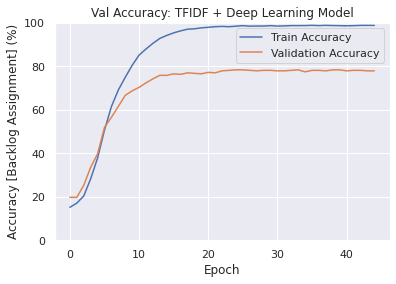

In [23]:
# Check Training History
plot_history(history_tfidf, "Val Accuracy: TFIDF + Deep Learning Model", save=True)

## Step 8: Saving the Model
In order to use the model we've just trained in production, we'll need to save the model and all of its dependencies. This way, we'll be able to easily reload the model in production to perform predictions. Below we save...

- `tfidf_vectorizer`: The TF/IDF Vectorizer was 'fit' to the training dataset, and its vocabulary encompasses all of the words that show up in our training emails. In order to prepare plain-text/ HTML files to be fed into our model during deployment, we'll need to use this vectorizer once again to transform that text/HTML into the vectors that our deep learning model expects as input.
- `label_to_id`: This variable stores a simple dictionary that maps prediction indices (indices of the labels in the one-hot-encoded label representation) to actual backlog-id names. Without this dictionary, we wouldn't be able to understanding the meaning of our model predictions.
- `assignment_model`: lastly, of course, we save the classifier itself.

In [24]:
# Generate a dictionary that maps prediction indicies 
# (indicies of one-hot-encoded labels) to actual backlog ID names 
label_to_id = {}
for i, col in enumerate(test_labels.columns):
    label_to_id[i] = col

# Test:
label_to_id[10]

'BL-3346'

In [25]:
# Create Directory to save into:
! mkdir -p ../saved_models/tfidf_model/
# Save tfidf_vectorizer
pickle.dump(tfidf_vectorizer, open("../saved_models/tfidf_model/tfidf_vectorizer.pkl", "wb"))
# Save assignment_model
assignment_model.save('../saved_models/tfidf_model/tfidf_classifier.h5')
# Save label_to_id dictionary
pickle.dump(label_to_id, open('../saved_models/tfidf_model/label_to_id.pkl', 'wb'))

## Step 9: Testing Model + Generating Predictions:
To generate model predictions, we apply the Monte Carlo Dropout confidence bounding approach described in ['Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning
'](https://arxiv.org/pdf/1506.02142.pdf). We've developed two prediction functions that use Monte Carlo Dropout under the hood
- `test_with_uncertainty` - designed to be used to test model accuracy on a test set, and
- `predict_with_uncertainty`, designed to be used in production to generate a prediction for a single email.
You can find the code for these functions in [MLFunctions.py](../nlp_engine/MLFunctions.py). We've listed the function headers below to describe how each of these functions work.

When we test our model, we'll use the function `test_with_uncertainty` to obtain our model's predictions for each sample in the test set, along with the associated confidence value for  each of those predictions. This way, we can evaluate the accuracy of the model at different confidence intervals.
```python
def test_with_uncertainty(model, test_features: pd.DataFrame, test_labels: pd.DataFrame, label_to_id: dict, n_iter=10) -> pd.DataFrame
    
    """
    USE FOR TESTING
    ---------------

    Parameters:

        - model: a keras model trained with Monte Carlo Dropout

        - test_features: one or multiple samples (1 sample = 1 vector of 
                         test_features).

        - test_labels: the ground-truth labels corresponding to the samples. 
                       (one-hot-encoded)

        - label_to_id: A dictionary that maps prediction indicies (indicies of
                       the softmax outputs of the model) to label names. 

        - n_iter: the number of stochastic forward passes you'd like your model 
                  to perform for each given test sample. i.e. for n_iter=10, the
                  function applies 10 distinct dropout schemas and generates
                  10 different softmax outputs from the model. It then takes the final or 'master'
                  prediction to be the maximum softmax index with the highest overall probability
                  (i.e. final prediction = average prediction over all 10 trials) and the uncertainty 
                  to be the Standard Deviation of the set of 10 softmax outputs (more variable softmax output 
                  = more uncertainty)
    
    Returns: preds_df, a dataframe of labels predicted by your model, ground truth lables, and prediction
             uncertainty values.
    """
    
def predict_with_uncertainty(model, test_features: pd.DataFrame, label_to_id: dict, n_iter=10) -> tuple
    
    """
    USE FOR DEPLOYMENT
    ------------------

    Wheras the above function is used during the testing phase (testing monte 
    carlo accuracies), this function should be used for deployment. Note that
    there are no ground-truth labels passed into the function.

    Parameters:

        - model: Save as above

        - test_features: a SINGLE sample (1 sample = 1 vector of 
                         test_features).

        - label_to_id: Save as above

        - n_iter: Same as above
   
    Returns: a tuple, including the predicted label value and an uncertainty value
             ... i.e. return  (prediction id, uncertainty)
    """
```

In [26]:
# Test the Model
preds_df = test_with_uncertainty(assignment_model, test_features, test_labels, label_to_id, n_iter=100)

In [27]:
# Visualize and evaluate the prediction/ uncertainty values
preds_df

,Prediction,Label,Uncertainty
0,BL-3289,BL-3289,0.028436
1,BL-3289,BL-3289,0.001387
2,GRP-3974,GRP-3974,0.091664
3,GRP-28665,GRP-28665,0.060137
4,GRP-20686,GRP-20686,0.039525
...,...,...,...
1082,GRP-13931,GRP-13931,0.014101
1083,GRP-13931,BL-2287,0.109725
1084,BL-2285,BL-2285,0.008118
1085,BL-752,BL-752,0.004115


Testing Accuracy
---

Now that we've gotten our model predictions, we can pass the resulting `preds_df` DataFrame into another function `get_monte_carlo accuracy`. `get_monte_carlo accuracy` takes as input a predictions DataFrame, as well as a threshold uncertainty score. The function will then return the model's accuracy on all test samples that were predicted with an uncertainty value *below* the threshold uncertainty score. Further, it will let us know how much of the test set was discarded when the confidence threshold was applied.

Ideally, you want to find a balance between accuracy and efficiency. It may be the case that that your model can achieve 80% accuracy on the entire test set (i.e. NO uncertainty threshold), however, your model can achieve a much higher 95% accuracy on 60% of the test set if you allow the model to throw emails that it is unable to confidently place into a queue for human review. In this case, you must decide whether you prefer
- An 80% accurate model that automates 100% of the work or...
- a 95% accurate model that automates 60% of the work.

To determine the right balance for you, feel free to play around with the threshold uncertainty value and determine which threshold is best for your use case.

**NOTE**: Do not change the `n_iter` value unless you truly understand what this parameter means. If you do decide to change the `n_iter` value, make sure that the model uses the exact same `n_iter` value in production (i.e. make sure that both test_with_uncertainty and predict_with_uncertainty take the same `n_iter` value. Changing the `n_iter` value alters the scale of the `uncertainty` metric, so we need to make sure `n_iter` is consistant across testing and production to ensure that the threshold uncertainty value we determine during testing works as we expect it to work in production.

--- 
### Steps:
- Test the models accuracy across the **entire** test set by setting the uncertainty threshold to `None`, and compare its accuracy to a dummy classifier (i.e. a model that classifies every email into the most frequently occuring backlog. 
- Show an example for how we can test the models accuracy at a particular uncertainty threshold. 
- Show a graph of the relationship between the percentage of testing data retained and the model accuracy
- Show how we can select an uncertainty thrshold based on a target accuracy, or a target ammount of data we want to retain in production (the percentage of the bug classification that will be automated by the model).

In [28]:
retained, accuracy = get_monte_carlo_accuracy(preds_df=preds_df, threshold=None)
print('Test set reduced to %', retained)
print('Accuracy : %', accuracy)

Test set reduced to % 100
Accuracy : % 78.84084636614536


In [29]:
# For reference, here is the zero-rule and random baseline accuracies
# on the test set:

# DummyClassifier only accepts numeric categorical labels, so we convert
# our one-hot-encoded labels back to standard levels before passing in:
int_train_labels = train_labels.idxmax(axis=1)
int_test_labels = test_labels.idxmax(axis=1)

clf = DummyClassifier(strategy='most_frequent')
clf.fit(train_features, int_train_labels)
print("Zero-Rule Baseline Accuracy: %", clf.score(test_features, int_test_labels) * 100)

clf = DummyClassifier(strategy='uniform')
clf.fit(train_features, int_train_labels)
print("Random (Uniform) Baseline Accuracy: %", clf.score(test_features, int_test_labels) * 100)

Zero-Rule Baseline Accuracy: % 18.39926402943882
Random (Uniform) Baseline Accuracy: % 2.391904323827047


In [30]:
# Accuracy with an uncertainty threshold applied:
retained, accuracy = get_monte_carlo_accuracy(preds_df=preds_df, threshold=0.04)
print('Test set reduced to %', retained)
print('Accuracy : %', accuracy)

Test set reduced to % 40.110395584176636
Accuracy : % 96.78899082568807


In [31]:
# Use this function to generate a prediction on a single email. 
# This function is not relevant in testing the model, but will be used to classify incoming emails later on in production
predict_with_uncertainty(assignment_model, test_features.iloc[0], label_to_id, n_iter=100)

('BL-3289', 0.026612099019358963)

92.05175600739372

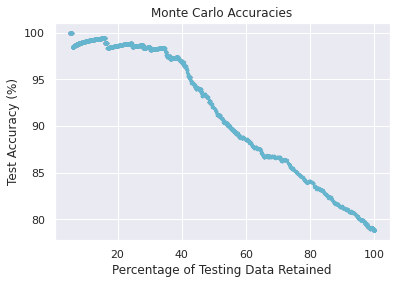

In [32]:
# Graph the trade-off between effeciency and accuracy:
graph_confidence(preds_df, save=True)

In [33]:
from MLFunctions import acc_to_uncertainty, proportion_to_uncertainty

### Select Threshold 
to use in production based on target ammount of data retained or based on target accuracy

In [34]:
# Retain 70% of data
threshold = proportion_to_uncertainty(preds_df, target_prop=70)
print('Threshold:', threshold)

% of test data retained 69.91720331186752
Exact accuracy 86.71052631578947
Threshold: 0.09997199118838754


In [35]:
# Reach 90% of accuracy
threshold = acc_to_uncertainty(preds_df, target_acc=90)
print('Threshold:', threshold)

% of test data retained 54.7378104875805
Exact accuracy 90.08403361344538
Threshold: 0.07020009347002944


In [36]:
# Deallocate the model:
clear_memory(assignment_model)